In [1]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import glob
import random
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
import os
import re

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [7]:
!unzip -qq "/content/gdrive/MyDrive/imagenet.zip"

#전처리

In [8]:
all_img_list = glob.glob('/content/imagenet1k/*/*')

In [9]:
all_img_list

['/content/imagenet1k/148_killer whale, killer, orca, grampus, sea wolf, Orcinus orca/023_3.jpg',
 '/content/imagenet1k/148_killer whale, killer, orca, grampus, sea wolf, Orcinus orca/019_5845.jpg',
 '/content/imagenet1k/148_killer whale, killer, orca, grampus, sea wolf, Orcinus orca/059_952.jpg',
 '/content/imagenet1k/148_killer whale, killer, orca, grampus, sea wolf, Orcinus orca/079_8482.jpg',
 '/content/imagenet1k/148_killer whale, killer, orca, grampus, sea wolf, Orcinus orca/003_2076.jpg',
 '/content/imagenet1k/148_killer whale, killer, orca, grampus, sea wolf, Orcinus orca/068_2255.jpg',
 '/content/imagenet1k/148_killer whale, killer, orca, grampus, sea wolf, Orcinus orca/071_3221.jpg',
 '/content/imagenet1k/148_killer whale, killer, orca, grampus, sea wolf, Orcinus orca/041_5440.jpg',
 '/content/imagenet1k/148_killer whale, killer, orca, grampus, sea wolf, Orcinus orca/000_5335.jpg',
 '/content/imagenet1k/148_killer whale, killer, orca, grampus, sea wolf, Orcinus orca/096_8556.

In [10]:
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split('/')[3])

In [11]:
def remove_number_prefix(label):
    return re.sub(r'^\d+_', '', label)


df['label'] = df['label'].apply(remove_number_prefix)

In [12]:
df

,img_path,label
0,"/content/imagenet1k/148_killer whale, killer, ...","killer whale, killer, orca, grampus, sea wolf,..."
1,"/content/imagenet1k/148_killer whale, killer, ...","killer whale, killer, orca, grampus, sea wolf,..."
2,"/content/imagenet1k/148_killer whale, killer, ...","killer whale, killer, orca, grampus, sea wolf,..."
3,"/content/imagenet1k/148_killer whale, killer, ...","killer whale, killer, orca, grampus, sea wolf,..."
4,"/content/imagenet1k/148_killer whale, killer, ...","killer whale, killer, orca, grampus, sea wolf,..."
...,...,...
99996,"/content/imagenet1k/623_letter opener, paper k...","letter opener, paper knife, paperknife"
99997,"/content/imagenet1k/623_letter opener, paper k...","letter opener, paper knife, paperknife"
99998,"/content/imagenet1k/623_letter opener, paper k...","letter opener, paper knife, paperknife"
99999,"/content/imagenet1k/623_letter opener, paper k...","letter opener, paper knife, paperknife"


In [13]:
train, val, _, _ = train_test_split(df, df['label'], test_size=0.5, stratify=df['label'], random_state=100)

In [14]:
train

,img_path,label
47032,/content/imagenet1k/941_acorn squash/003_6315.jpg,acorn squash
28052,/content/imagenet1k/504_coffee mug/068_6007.jpg,coffee mug
49006,"/content/imagenet1k/773_saltshaker, salt shake...","saltshaker, salt shaker"
2810,/content/imagenet1k/797_sleeping bag/000_258.jpg,sleeping bag
56348,/content/imagenet1k/715_pickelhaube/052_5820.jpg,pickelhaube
...,...,...
68503,"/content/imagenet1k/629_lipstick, lip rouge/04...","lipstick, lip rouge"
36326,/content/imagenet1k/698_palace/089_5639.jpg,palace
22806,/content/imagenet1k/624_library/095_3345.jpg,library
39853,"/content/imagenet1k/413_assault rifle, assault...","assault rifle, assault gun"


In [15]:
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'])
val['label'] = le.transform(val['label'])

#custom dataset

처음에 내가 짠거. https://dacon.io/competitions/official/236082/codeshare/7887 참고함


In [16]:
import cv2
from torch.utils.data import Dataset
class CustomDataset(Dataset):
   def __init__(self, img_paths, label_paths, transforms=None):
     self.transforms = transforms
     self.img_paths = img_paths
     self.label_paths = label_paths

   def __getitem__(self, index):
     img_path = self.img_paths[index]
     image = cv2.imread(img_path)

     if self.transforms is not None:
       image = self.transforms(image=image)['image']

     if self.label_paths is not None:
       label = self.label_paths[index]
       return image, label
     else:
       return label
   def __len__(self):
     return len(self.img_paths)

In [17]:
train_transform = A.Compose([
                            A.Resize(224,224),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(224,224),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [18]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = 256, shuffle=False, num_workers=0)

In [19]:
val_dataset = CustomDataset(val['img_path'].values, val['label'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=0)

# model

음... 근데 이거 shortcut을 어떤 식으로 구현해야 햐지?

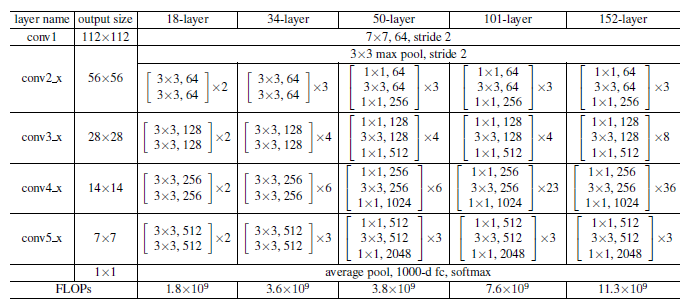

일단 논문에서 말한거처럼 블록으로 구현하자.

아니 zero_padding이 논문에만 나오고 구조 설명에는 없어서 따로 kernel을 계산했다. (224-7+2p)/2 + 1 = 112 인데 p가 3이 되어야 말이 된다.

In [20]:
import torch.nn as nn

class residual_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(residual_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # 일단 이거 입력과 출력의 채널 값이 다를 때 바로 downsampling을 한다는 의미다.
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        # 입출력이 다를 때 그 잔차를 학습하도록함.
        out += identity
        out = self.relu(out)
        return out

class Resnet(nn.Module):
    def __init__(self, num_classes=1000):
        super(Resnet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = nn.Sequential(
            residual_block(64, 64),
            residual_block(64, 64)
        )
        self.layer2 = nn.Sequential(
            residual_block(64, 128, stride=2),
            residual_block(128, 128)
        )
        self.layer3 = nn.Sequential(
            residual_block(128, 256, stride=2),
            residual_block(256, 256)
        )
        self.layer4 = nn.Sequential(
            residual_block(256, 512, stride=2),
            residual_block(512, 512)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# 학습

In [21]:
import copy

In [22]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)

    best_score = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(1, 11):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            output = model(imgs)
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')

        if scheduler is not None:
            scheduler.step(_val_score)

        if best_score < _val_score:
            best_score = _val_score
            best_model_wts = copy.deepcopy(model.state_dict())

    best_model = model
    best_model.load_state_dict(best_model_wts)
    return best_model


In [23]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)

            pred = model(imgs)

            loss = criterion(pred, labels)

            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()

            val_loss.append(loss.item())

        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')

    return _val_loss, _val_score

In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [25]:
for item in train_loader:
    print(item)
    break  # 첫 번째 배치만 출력합니다.


[tensor([[[[-1.6042, -1.8953, -1.6042,  ..., -1.8953, -1.9295, -1.9124],
          [-1.8439, -1.7925, -1.9124,  ..., -1.9295, -1.9295, -1.9467],
          [-1.7754, -1.8268, -1.9124,  ..., -1.9124, -1.9124, -1.9980],
          ...,
          [-2.0665, -2.0665, -2.0152,  ..., -1.7754, -1.7412, -1.7583],
          [-2.0494, -2.0323, -1.9809,  ..., -1.7583, -1.8097, -1.7754],
          [-2.0837, -1.9980, -1.9980,  ..., -1.8268, -1.8610, -1.8782]],

         [[-0.7752, -1.0728, -0.8803,  ..., -1.7381, -1.7556, -1.7381],
          [-1.0903, -1.1604, -1.2829,  ..., -1.7906, -1.7731, -1.7906],
          [-1.1078, -1.1954, -1.4055,  ..., -1.8081, -1.7906, -1.8431],
          ...,
          [-2.0182, -1.9832, -1.8957,  ..., -1.5630, -1.5805, -1.5980],
          [-1.9832, -1.9832, -1.8957,  ..., -1.5455, -1.6506, -1.5980],
          [-2.0182, -1.9657, -1.9832,  ..., -1.5980, -1.7206, -1.6331]],

         [[ 0.6182,  0.5659,  0.6008,  ..., -0.4101, -0.4101, -0.5321],
          [ 0.5485,  0.4614, 

In [26]:
model = Resnet()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch [1], Train Loss : [7.72938] Val Loss : [6.60025] Val Weighted F1 Score : [0.00090]


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch [2], Train Loss : [6.46130] Val Loss : [6.47609] Val Weighted F1 Score : [0.00169]


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch [3], Train Loss : [6.07943] Val Loss : [5.94671] Val Weighted F1 Score : [0.00912]


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch [4], Train Loss : [5.69008] Val Loss : [5.58654] Val Weighted F1 Score : [0.01708]


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch [5], Train Loss : [5.40950] Val Loss : [5.36927] Val Weighted F1 Score : [0.02441]


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch [6], Train Loss : [5.22565] Val Loss : [5.30624] Val Weighted F1 Score : [0.03205]


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch [7], Train Loss : [5.01616] Val Loss : [5.11064] Val Weighted F1 Score : [0.04682]


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch [8], Train Loss : [4.77172] Val Loss : [4.87454] Val Weighted F1 Score : [0.06528]


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch [9], Train Loss : [4.56455] Val Loss : [4.62874] Val Weighted F1 Score : [0.08107]


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch [10], Train Loss : [4.38661] Val Loss : [4.52912] Val Weighted F1 Score : [0.09384]
